In [1]:
!pip install torch torchvision matplotlib numpy

### Import necessary Libraries

In [2]:
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
import pandas as pd
import os

In [3]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

# Get the available devices
devices = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print('number of available GPU: ',torch.cuda.device_count())  # Should print the number of visible devices

# Print the available devices
print("Available devices:")
for device in devices:
    print(f"- {device}")
device = torch.device("cuda:0")  # Use the first GPU

# Print the current device
#print(f"Current device: {torch.cuda.current_device()}")

number of available GPU:  1
Available devices:
- <torch.cuda.device object at 0x7f22d54878d0>


In [4]:
torch.cuda.mem_get_info(device=device)

(8014462976, 8512602112)

In [5]:
!nvidia-smi

Mon Jul  1 00:40:58 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:65:00.0  On |                  N/A |
| 48%   44C    P0    29W / 105W |    475MiB /  8118MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Multiclass classification
#Predict if an asset will fail within two different intervals related to the two different decisions


`os`: This module provides functions for interacting with the operating system. It's commonly used for tasks such as file manipulation and directory operations.<br>
`sklearn.preprocessing`: This module from scikit-learn provides functions for preprocessing data, such as scaling, normalization, and encoding categorical variables.<br>
`sklearn.metrics`: This module contains functions for evaluating model performance, such as computing confusion matrices, recall scores, and precision scores.<br>
`multiclass_model_w1_30.h5`:The .h5 extension indicates that the model will be saved in the Hierarchical Data Format version 5 (HDF5) format, which is commonly used for storing large numerical datasets. The model will be saved with the filename **multiclass_model_w1_30.h5.**

In [7]:
# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
#from tensorflow.keras.models import Sequential,load_model
#from tensorflow.keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'multiclass_model_w1_30.h5'# This file then contains the already trained network, so that you don't have to retrain every time

## Data Ingestion


In [8]:
# read training data - It is the aircraft engine run-to-failure data.
from data_preprocessor import DataPreprocessor

# Initialize the preprocessor with the path to your training data file
preprocessor = DataPreprocessor('PM_train.txt')

# Preprocess the data
seq_array, dummy_label_array, seq_array_validation, dummy_label_array_validation = preprocessor.preprocess()
seq_array.shape, dummy_label_array.shape, seq_array_validation.shape, dummy_label_array_validation.shape

((12138, 50, 25), (12138, 3), (1742, 50, 25), (1742, 3))

`train_df.sort_values(['id','cycle'])`: This line sorts the DataFrame **train_df** first by the 'id' column and then by the 'cycle' column. It ensures that the data is ordered by engine ID and cycle number, which may be necessary for certain analyses or modeling tasks. The sorted DataFrame is then assigned back to the variable **train_df**.

## Data Preprocessing
data preprocessing step, particularly for labeling the data for training purposes. Let's break down what each part of the code does:


>`Data Labeling`: This part calculates the Remaining Useful Life (RUL) or Time to Failure for each engine by finding the maximum cycle number (cycle) for each engine ID (id). The result is stored in a DataFrame rul with columns 'id' and 'max'.<br>

>`Merge RUL with Training Data`:the RUL information is merged back into the original training DataFrame **train_df** based on the engine ID. This allows each row in train_df to have the corresponding maximum cycle number as well.<br>

>`Calculate RUL`: This line calculates the RUL by subtracting the current cycle number ('cycle') from the maximum cycle number ('max') for each engine. This represents how many more cycles the engine is expected to operate before failure.<br>
>`Drop Unnecessary Columns`: After calculating RUL, the 'max' column, which was used temporarily to calculate RUL, is dropped from the DataFrame as it's no longer needed.<br>

> `Labeling for Classification`: This part assigns labels to each data point based on the calculated RUL. It defines thresholds `w1` and `w0`, and assigns:
>> * Label 1 ('label1') as 1 if RUL is less than or equal to 'w1', and 0 otherwise.
>> * Label2 ('label2') as 1 if RUL is less than or equal to 'w1', 2 if RUL is less than or equal to 'w0', and 0 otherwise.

 Now I want to separate the train_df set into a training/validation/test set. I will use 80% training sets for the training and 10% training sets as validation sets for hyperparameter tuning and the remaining 10% as test set for the PdM policy.

I separate into training and validation and test set before any data scaling is performed

Perform the min max scaling on the training data and validation dataset
use min_max_scaler.fit_transform()

>`Create a copy of the cycle column`: This line creates a new column named 'cycle_norm' in the train_df DataFrame and initializes it with the values from the original 'cycle' column. This column will be normalized later.<br>
> `Select columns for normalization`: This line selects all columns from **train_df** except 'id', 'cycle', 'RUL', 'label1', and 'label2'. These columns are the ones that will undergo normalization.


> `Initialize MinMaxScaler`: This line initializes a MinMaxScaler object from the scikit-learn preprocessing module. This scaler will be used to perform Min-Max normalization.<br>
> `Perform Min-Max normalization`: This line applies Min-Max normalization to the selected columns (`cols_normalize`) of the `train_df` DataFrame.<br>
> `min_max_scaler.fit_transform(train_df[cols_normalize])` computes the Min-Max normalization for the selected columns.<br>
> The resulting normalized values are stored in a new DataFrame called `norm_train_df`, with the same index as `train_df`.

> `Join normalized DataFrame with the original DataFrame`: This line joins the normalized DataFrame (`norm_train_df`) with the original DataFrame (`train_df`) excluding the columns that were normalized.<br>
> The resulting DataFrame `join_df` contains both the normalized columns and the original columns that were not normalized.


`Reorder columns`:
> * This line reorders the columns of `join_df` to match the original order of columns in `train_df`.
> * The reordered DataFrame is then assigned back to `train_df`, effectively replacing the original DataFrame with the normalized version.






## Vanilla Transformer

When you use `sequence_cols.extend(sensor_cols)`, it adds each element of `sensor_cols` to the end of `sequence_cols`.<br>
After this operation, `sequence_cols` will contain 25 elements: 4 operational settings followed by 21 sensor readings.



## generate sequences for each engine
> * This creates a generator expression that iterates over unique engine IDs in the training data.<br>
> * For each engine, it generates sequences using the `gen_sequence` function defined earlier.<br>
> * Each sequence is a list of sensor data, and multiple sequences are generated for each engine.<br>



> * This concatenates all the generated sequences into a single numpy array.
> * It converts the array to `float32` data type.
> * The resulting `seq_array` contains the sequences of sensor data, with shape `(num_sequences, sequence_length, num_features)`.


In [ ]:
# we always take the measurements of the last 50 cycles as input!
# Every sequence is reduced by a length of 50 (=sequence_length). We have 80 training sets, 80*50 = 4000 "less" inputs
# train_df.shape = (16138, 30)
# seq_array.shape = (12138, 50, 25)

`Function Signature:` This function efficiently generates labels for each sequence of sensor data. It ensures that the labels are correctly aligned with the sequences and handles the special case where the first sequence uses the last label as its target.





> This function takes three arguments:
>> * `id_df:` DataFrame containing data for a specific engine (id).<br>
>> * `seq_length`: Length of the sequence window.<br>
>> * `label`: List of column names representing the labels.

`Data Preparation:`
> * `data_matrix = id_df[label].values:`
>> * This line extracts the columns specified by label from the DataFrame id_df and converts them to a numpy array.<br>
>> * It selects only the relevant label(s) needed for generating sequences.<br>

`Label Generation:`
> * `num_elements:`This line calculates the number of rows (elements) in the data matrix, which corresponds to the number of labels.<br>
> * `return data_matrix[seq_length:num_elements, :]:`
>> * This line returns the labels associated with each sequence.<br>
>> * It removes the first `seq_length` labels because, for each engine (`id`), the first sequence of size `seq_length` uses the last label as its target. The previous labels are discarded.<br>
>> * All subsequent sequences for the same engine (`id`) will have one label associated with them step by step.<br>








When modeling multi-class classification problems using neural networks,<br>
it is good practice to reshape the output attribute from a vector that contains values for each class value to be<br>
a matrix with a boolean for each class value and whether or not a given instance has that class value or not.<br>
This is called one hot encoding or creating dummy variables from a categorical variable.<br>

from tensorflow.keras.utils import to_categorical<br>

`to_categorical` is a utility function in Keras that converts class vectors (integers) to binary class matrices.<br>
`dummy_label_array = to_categorical(label_array):`This line applies one-hot encoding to the `label_array`.<br>
`label_array` contains the labels associated with each sequence, where each label represents a class or category.<br>
> * One-hot encoding converts these integer labels into binary vectors, where each vector has a length equal to the number of classes and contains a 1 in the position corresponding to the class and 0s elsewhere.





In [9]:
dummy_label_array

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [10]:
dummy_label_array_validation

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [11]:
dummy_label_array_validation.shape

(1742, 3)

In [12]:
dummy_label_array.shape

(12138, 3)

In [13]:
nb_features = seq_array.shape[2]
nb_out      = dummy_label_array.shape[1]
nb_features, nb_out

(25, 3)

`Extracting Feature and Output Dimensions:`
> `nb_features:`Determines the number of features in the input sequence data.<br>
> `nb_out:`Determines the number of output classes. It's extracted from the shape of the label array.<br>

`Defining the Model Architecture:` describe in the code below.
`Compiling the Model:` `model.compile(...)` Here, `categorical_crossentropy` is used as the loss function for multi-class classification.

`Model Summary:`Prints a summary of the model architecture, including the layers and their parameters.

`Training the Model:` `model.fit(...):` Trains the model on the training data. It specifies the input data (`seq_array`) and the corresponding labels (`dummy_label_array`). Other parameters include the number of epochs, batch size, validation split, verbosity, and callbacks.<br>


`history.history.keys():` After training, this prints the keys of the history object, which contains information about training and validation metrics over each epoch.



### Define the Dataset:
Create a custom dataset class to handle your multivariate time series data with labels.




In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/LSTM_Antonis')

`Shuffling Batches:` By setting `shuffle=True` in the `DataLoader` for the training set, you ensure that the order of batches is shuffled each epoch. This maintains the temporal structure within each batch while still introducing variability in the order in which batches are processed.<br>

`DataLoader for Validation:` Ensure `shuffle=False` for the validation set to maintain the sequence order during validation.

In [22]:
# Import custom classes
import torch
from torch.utils.data import TensorDataset, DataLoader

from dataset import MultivariateTimeSeriesDataset
from model import TransformerTimeSeriesModel

# Load parameters from JSON file
with open('params.json', 'r') as f:
    params = json.load(f)

# Example usage with seq_array and dummy_var
#seq_array --> (12138, 50, 25)  # use this as your actual data
#dummy_var --->  (12138, 3) # use this as your actual dummy variable (3 classes)

#train_indices, val_indices = train_test_split(np.arange(len(seq_array)), test_size=0.05, random_state=42)
# Check for data leakage
#assert len(set(train_indices).intersection(set(val_indices))) == 0, "Data leakage detected between training and validation sets"

train_dataset = MultivariateTimeSeriesDataset(seq_array, dummy_label_array, params['seq_length'])
val_dataset = MultivariateTimeSeriesDataset(seq_array_validation, dummy_label_array_validation, params['seq_length'])

# Shuffle batches by setting shuffle=True in DataLoader
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)


### Define the Transformer Model:
Implement the vanilla Transformer architecture, ensuring it takes the dummy variable as an input.



In [23]:
# Instantiate the model using parameters from the JSON file
model = TransformerTimeSeriesModel(
    input_dim=params['input_dim'],
    model_dim=params['model_dim'],
    num_heads=params['num_heads'],
    num_layers=params['num_layers'],
    seq_length=params['seq_length'],
    num_classes=params['num_classes'],
    dropout_rate=params['dropout_rate']
).to(device)

In [24]:
model

TransformerTimeSeriesModel(
  (input_embedding): Linear(in_features=25, out_features=16, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=64, bias=True)
          (dropout): Dropout(p=0.2868566573951219, inplace=False)
          (linear2): Linear(in_features=64, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2868566573951219, inplace=False)
          (dropout2): Dropout(p=0.2868566573951219, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamica

In [25]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

24371

In [26]:
# Expand val_dummy to match the sequence length of val_data
#val_dummy_expanded = np.repeat(dummy_label_array_validation[:, np.newaxis, :], params['seq_length'], axis=1)

#print(f'val_dummy_expanded shape: {val_dummy_expanded.shape}')  # Should print: val_dummy_expanded shape: (1742, 50, 3)


In [27]:
len(train_loader)

3035

In [28]:
params

{'input_dim': 25,
 'model_dim': 16,
 'num_heads': 2,
 'num_layers': 3,
 'seq_length': 50,
 'num_classes': 3,
 'dropout_rate': 0.2868566573951219,
 'learning_rate': 0.008660297626080152,
 'batch_size': 4,
 'num_epochs': 5,
 'weight_decay': 0.0008257506721260046,
 'patience': 5}

In [29]:
'''
for batch in train_loader:
    print(batch)
'''

'\nfor batch in train_loader:\n    print(batch)\n'

### Training the model

Define the training loop with the loss function and optimizer, and include the dummy variable in the forward pass.



In [30]:
#reconstruction_criterion = nn.MSELoss()
torch.optim 
classification_criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=params['patience'])

# Learning rate scheduler with ReduceLROnPlateau for early stopping
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=params['patience'], verbose=True)


In [31]:
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'

In [33]:
# Instantiate early stopping
#early_stopping = EarlyStopping(patience=params['patience'], verbose=True)

# Set up model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_params = {k: v for k, v in params.items() if k not in ['learning_rate', 'batch_size', 'num_epochs', 'weight_decay','patience']}
model = TransformerTimeSeriesModel(**model_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])


num_epochs = params['num_epochs']
train_losses = []
val_losses  = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, dummies = batch
        inputs = inputs.float().to(device)
        dummies = dummies.float().to(device)

        outputs_class = model(inputs)

        outputs_reshaped = outputs_class.view(-1, params['num_classes'])
        dummies_reshaped = dummies.view(-1, params['num_classes'])
        loss = criterion(outputs_reshaped, dummies_reshaped.argmax(dim=1))

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(average_epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {average_epoch_loss}')

    # Validation
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, dummies = batch
            inputs = inputs.float().to(device)
            dummies = dummies.float().to(device)

            outputs_class = model(inputs)

            outputs_reshaped = outputs_class.view(-1, params['num_classes'])
            dummies_reshaped = dummies.view(-1, params['num_classes'])
            val_loss = criterion(outputs_reshaped, dummies_reshaped.argmax(dim=1))

            val_epoch_loss += val_loss.item()
    
    #scheduler.step(val_epoch_loss)

    average_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss}')

    # Add your early stopping logic here if needed


Epoch 1/5, Training Loss: 0.6489263273714205
Epoch 1/5, Validation Loss: 0.5920122267182814
Epoch 2/5, Training Loss: 0.6407286782879413
Epoch 2/5, Validation Loss: 0.5964255237251247
Epoch 3/5, Training Loss: 0.6413671656240152
Epoch 3/5, Validation Loss: 0.5887445245587498
Epoch 4/5, Training Loss: 0.6409338089838452
Epoch 4/5, Validation Loss: 0.5924541114940556
Epoch 5/5, Training Loss: 0.6413560569654579
Epoch 5/5, Validation Loss: 0.5876542239560993


In [34]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

24371

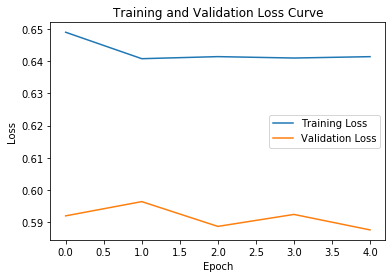

In [35]:
# Plot the training and validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

In [ ]:
from tensorflow_addons.layers import TransformerEncoder, TransformerDecoder
from tensorflow.keras.layers import Dense, Dropout

# Next, we build a deep network.
# The first layer is a TransformerEncoder layer followed by a TransformerDecoder layer.
# Dropout is also applied after each layer to control overfitting.
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

# Initializes a sequential model, which allows you to build a model layer by layer.
model = Sequential()

# Adds a TransformerEncoder layer to the model.
model.add(TransformerEncoder(
    head_size=64,
    num_heads=8,
    ff_dim=256,
    dropout=0.2,
    input_shape=(sequence_length, nb_features)
))

# Adds a TransformerDecoder layer to the model.
model.add(TransformerDecoder(
    head_size=64
    num_heads=8,
    ff_dim=256,
    dropout=0.2
))
model.add(Dropout(0.2))

# Adds a dense (fully connected) layer to the model with a softmax activation function. This layer produces the output classes.
model.add(Dense(units=nb_out, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, dummy_label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

# Every time I retrain the algorithm I get different training results, i.e., also different evaluation of the decisions

## Model Evaluation on Validation set created during the training (i.e., validation_split=0.05)

In [ ]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("model_accuracy.png")

In [ ]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, dummy_label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

`y_pred = (model.predict(seq_array) > 0.5).astype("int32"):` Predicts the abels for the input sequences using the trained model. The predictions are hresholded at 0.5, meaning that any output probability greater than 0.5 is considered as class 1, otherwise class 0. The predictions are then converted to integers (0 or 1).<br>

`y_true = dummy_label_array:` Sets the true labels from the dummy label array, which represents the actual labels of the data.
then print the **confusion_matrix**

`cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)):` Computes the confusion matrix using the true labels (`y_true`) and the predicted labels `(y_pred). argmax(axis=1)` is used to convert one-hot encoded labels back to their original integer form before computing the confusion matrix.




In [ ]:
# make predictions and compute confusion matrix
# y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_pred = (model.predict(seq_array) > 0.5).astype("int32") # this way (>0.5) the outcome goes from a probability to 0,1
y_true = dummy_label_array

# test_set = pd.DataFrame(y_pred)
# # test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

## Second PdM policy evaluation on the test set.

For each test set, I need to give the on-line sensor data as input to the trained Transformer.


In [ ]:
if os.path.isfile(model_path):
    estimator = load_model(model_path)

In [ ]:
# Assumptions for the costs, taken by the 2019 RESS paper
C_p    = 100
C_c    = 1000
C_unav = 10
C_inv  = 1
DT     = 10  # Decisions can be taken every DT=10
L      = 20  # lead time

In [ ]:
array_decisions = np.arange(0,400,10) # decisions can only be made every DT = 10 cycles

In [ ]:
# estimator.predict(seq_array_validation_k).reshape(3) returns a vector with 3 elements
# [Pr(RUL>w1), Pr(w0<RUL<=w1), Pr(RUL<=w0)]

In [ ]:
test_df['cycle_norm'] = test_df['cycle']

In [ ]:
test_df.head()

## Second PdM policy evaluation on a the whole validation data set (ids 81 to 100)


In [ ]:
costs_rep_array   = np.zeros(20) # An array to store costs related to replacements.

costs_delay_array = np.zeros(20) # An array to store costs related to delays.
costs_stock_array = np.zeros(20) # An array to store costs related to stock.

t_LC_array        = np.zeros(20) # An array to store lead time.
t_order_array     = np.zeros(20) # An array to store order time.

> 1. Initializes a counter variable to 0.
> 2. Iterates over unique IDs in the `test_df` DataFrame.
> 3. For each ID:
>> * Sets flags for preventive replacement and ordering to False.<br>
>> * Iterates over cycles within the range of the DataFrame.<br>
>> * Checks if the current cycle is in the `array_decisions`.<br>
>> * If it is, preprocesses the validation data for the LSTM model.<br>
>> * Predicts the probability of RUL being smaller than w1 and DT (decision time) using the trained model.<br>
>> * Evaluates decision heuristics:
>>> * If no order has been placed yet and the cost of preventive replacement is less than or equal to the cost of waiting until `w1`, orders the component and sets the order time.<br>
>>> * If the cost of preventive replacement is less than or equal to the cost of waiting until `DT`, performs preventive replacement, calculates related costs, and breaks the loop.<br>
>> If preventive replacement is not performed:
>>> * Sets the component failure time to the last cycle in the ID's data.<br>
>>> * Sets replacement costs to `C_c`.<br>
>>> * Calculates delay costs based on whether an order has been placed.<br>
>> * Prints diagnostic information for each iteration.
>> * Increments the counter.


This code essentially simulates a decision-making process for component maintenance based on predictive models and cost considerations.








In [ ]:
counter = 0
for id in test_df['id'].unique():
    print('ID:', id)
    preventive_replacement = False
    order                  = False

    for cycle in range(test_df[test_df['id']==id].shape[0]-sequence_length+1):

        if cycle in array_decisions:

            norm_validation_df = pd.DataFrame(min_max_scaler.transform(test_df[test_df['id']==id][cols_normalize][:sequence_length+cycle]),
                 columns=cols_normalize,
                 index=test_df[test_df['id']==id][:sequence_length+cycle].index)

            join_df = test_df[test_df['id']==id][:sequence_length+cycle][test_df[test_df['id']==id][:sequence_length+cycle].columns.difference(cols_normalize)].join(norm_validation_df)
            validation_df_eval_online = join_df.reindex(columns = test_df[test_df['id']==id][cycle:sequence_length+cycle].columns)

            seq_array_validation_k = validation_df_eval_online[sequence_cols].values[cycle:sequence_length+cycle]
            seq_array_validation_k = np.asarray(seq_array_validation_k).astype(np.float32).reshape(1,sequence_length, nb_features)
            prob_RUL_smaller_DT    = estimator.predict(seq_array_validation_k).reshape(3)[2]
            prob_RUL_smaller_w1    = estimator.predict(seq_array_validation_k).reshape(3)[1]

            print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
            print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)


            # evaluate decision heuristics
            if order == False:
                if C_p <= prob_RUL_smaller_w1*C_c:
                    print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
                    print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)
                    t_order_array[counter] = sequence_length+cycle
                    order = True
                    print('component ordering at cycle:', t_order_array[counter])

            if C_p <= prob_RUL_smaller_DT*C_c:
                print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)

                t_LC_array[counter] = sequence_length+cycle
                costs_rep_array[counter] = C_p
                print('preventive replacement informed at cycle:', t_LC_array[counter])
                # print('component lifecycle:', t_LC)
                preventive_replacement = True
                costs_delay_array[counter] = max(t_order_array[counter]+L-t_LC_array[counter], 0) * C_unav

                costs_stock_array[counter]  = max(t_LC_array[counter] -(t_order_array[counter]+L), 0)*C_inv
                # print('delay time', max(t_order+L-t_LC, 0))
                # print('cost_delay_id:',cost_delay_id)
                # print('cost of stock:', cost_stock_id)
                break

    if preventive_replacement == False:
        t_LC_array[counter] = test_df[test_df['id']==id]['cycle'].iloc[-1]
        print('Component failure at t:', t_LC_array[counter])
        costs_rep_array[counter] = C_c

        if order == False:
            costs_delay_array[counter] = L * C_unav
        else:
            costs_delay_array[counter] = max(t_order_array[counter]+L-t_LC_array[counter], 0) * C_unav
            costs_stock_array[counter] = max(t_LC_array[counter] -(t_order_array[counter]+L), 0)*C_inv

    print('True failure:', test_df[test_df['id']==id]['cycle'].iloc[-1])
    print('-----------------------------------------')
    counter+=1

In [ ]:
costs_rep_array

In [ ]:
costs_delay_array

In [ ]:
costs_stock_array

In [ ]:
costs_tot = costs_rep_array+costs_delay_array+costs_stock_array

In [ ]:
costs_tot

In [ ]:
t_LC_array

In [ ]:
t_order_array

### This code calculates the expected cost per unit time using the LSTM model. It computes the mean of the total costs divided by the mean of the time to component failure (t_LC_array). This metric gives an estimate of the average cost incurred per unit time in the system, considering both maintenance and operational costs.

In [ ]:
expected_cost_LSTM = np.mean(costs_tot) / np.mean(t_LC_array)
expected_cost_LSTM

This code segment calculates the expected cost per unit time assuming perfect prognostics.
`1. Perfect Prognostics Calculation:`
> * It initializes an array `t_LC_perfect_array` to store the time of component failure for each unit in the validation dataset. This is calculated by dividing the last observed cycle number by the decision interval DT and then flooring the result to get the last decision cycle before failure.
> * The loop iterates over each unique ID in the validation dataset, calculates the time of component failure for each unit, and stores it in
`t_LC_perfect_array`.<br>
> * `math.floor()` is used to round down the result to the nearest multiple of `DT`.
> * Finally, the loop increments the counter for each unit.<br>

`2. Cost Calculation:`
> * `costs_perfect_array` is initialized with a value of `C_p`, representing the cost of preventive replacements. In a perfect scenario, only preventive replacements are made.
> * This array holds the same cost value for each unit in the validation dataset.

`3. Expected Cost Calculation:`
> * `expected_cost_perfect` is calculated by taking the mean of `costs_perfect_array` and dividing it by the mean of `t_LC_perfect_array`.
> * This calculation provides an estimate of the average cost per unit time assuming perfect prognostics, where components are replaced preventively at regular intervals.









In [ ]:
# Perfect prognostics
import math
t_LC_perfect_array  = np.zeros(20)
counter=0
for id in validation_df['id'].unique():
    t_LC_perfect_array[counter] = math.floor(validation_df[validation_df['id']==id]['cycle'].iloc[-1] /DT) * DT
    counter+=1

costs_perfect_array = np.ones(20)*C_p # a perfect policy will only lead to preventive replacements

expected_cost_perfect = np.mean(costs_perfect_array)/np.mean(t_LC_perfect_array)
expected_cost_perfect


In [ ]:
t_LC_perfect_array

In [ ]:
# evaluation of the metric defined in the paper
M = (expected_cost_LSTM - expected_cost_perfect) / expected_cost_perfect
M # it obtains a very small value

In [ ]:
M*100